In [1]:
import pandas as pd  #pandas用于数据清洗
import numpy as np  #numpy用于矩阵运算
import matplotlib.pyplot as plt  #matplotlib用于作图，分析数据
import seaborn as sns  #seaborn用于高级作图，数据可视化
import re  #python中的正则表达式包

from matplotlib.font_manager import FontProperties  #用于为matplotlib设置中文字体

数据清洗 负责人：孙川

In [2]:
#为seaborn设置中文字体，没有下面两行的话seaborn和matplotlib作图不能显示中文
#mfont = FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf', size=14)
#sns.set(font = mfont.get_name())

#使用pandas自带的方法读取excel文件
raw_data = pd.read_excel('expances.xlsx', 'sheet1', index_col='userid', na_values=['#N/A'])

raw_data是存放整个excel内容的DataFrame对象
car_data存放的是raw_data里所有车辆的数据，也是DataFrame对象

下面的代码获取了raw_data里所有车辆的数据

In [3]:
#获取excel前三行的车辆数据
car_raw_data = raw_data.iloc[:, :4]
car_data = car_raw_data.dropna(how='any')  #dropna 用于去除数据中所有的空值
car_lowist_price = car_data['报价'].apply(lambda x: re.findall(r'\d+\.?\d*', x)[0])  #lambda表达式中使用了正则表达式将车辆的
car_highist_price = car_data['报价'].apply(lambda x: re.findall(r'\d+\.?\d*', x)[1]) #最高价和最低价读取了出来

#将最低价和最高价插入到汽车数据中
car_data.insert(3, '最低报价', pd.to_numeric(car_lowist_price))
car_data.insert(4, '最高报价', pd.to_numeric(car_highist_price))

#通过最高价和最低价计算用mean函数计算中间价
car_mean_price = car_data.iloc[:, 3:5].mean(1)
car_data.insert(5, '中间报价', car_mean_price)

#car_data.to_csv('car_info_from_expances')

下面的代码从raw_data中获取了一些可能与用户车辆价格相关的数据，我们从所有数据中挑选了几列很有可能对用户
车辆价格有联系的数据，存放在car_price_factor中

In [4]:
#截取部分列暂时存放在pieces中
pieces = [raw_data.iloc[:, 4:9], raw_data.iloc[:, 14], raw_data.iloc[:, 17], raw_data.iloc[:, 76:]]

#将pieces中的几列组合起来，去掉没有用的列
car_price_factor = pd.concat(pieces, axis=1)
car_price_factor.drop(car_price_factor.columns[[8, 10, 12, 14, 16]], axis=1, inplace=True)

#计算用户消费城市的数量存放在cities中
cities = car_price_factor.iloc[:, 7:]
cities.fillna(0, inplace=True)
cities[cities != 0] = 1
cities['消费城市数量'] = cities.apply(lambda x: x.sum(), axis=1)
cities = cities.iloc[:, 5]

#最后将城市数量合并到车辆价格影响因素中
car_price_factor = car_price_factor.iloc[:, :7]
car_price_factor = pd.merge(car_price_factor, cities.to_frame(name='消费城市数量'), on='userid')

下面的代码将车辆数据和车辆价格因素数据整合成了一个DataFrame叫expances_data

In [5]:
expances_data = pd.merge(car_data, car_price_factor, on='userid')
expances_data = expances_data.dropna(how='any')
expances_data

,型号,品牌,年份,最低报价,最高报价,中间报价,报价,性别,年龄段,借记卡数,贷记卡数,近1年单笔交易金额最大值,近1年消费总笔数,近1年消费总金额,消费城市数量
userid,,,,,,,,,,,,,,,
3,A6,奥迪,2002.0,30.8,54.2,42.50,[ 30.8 - 54.2 ] 万,男,4.0,2,0,1660.00,5,3194.00,1
5,嘉年华,福特,2013.0,8.0,12.3,10.15,[ 8.0 - 12.3 ] 万,男,4.0,1,1,3166.63,1,3166.63,1
6,福克斯,福特,2009.0,11.9,15.4,13.65,[ 11.9 - 15.4 ] 万,男,5.0,1,1,2374.10,18,7519.25,3
7,福克斯,福特,2009.0,11.9,15.4,13.65,[ 11.9 - 15.4 ] 万,女,5.0,1,0,2450.00,6,5671.68,1
9,普拉多,丰田,2004.0,53.1,63.0,58.05,[ 53.1 - 63.0 ] 万,女,6.0,1,0,14.69,1,14.69,1
10,宝来,大众,2011.0,10.8,14.8,12.80,[ 10.8 - 14.8 ] 万,女,5.0,2,1,500.00,4,1089.70,1
12,DX7,东南,2015.0,10.0,14.2,12.10,[ 10.0 - 14.2 ] 万,男,6.0,1,4,1011.00,3,2041.94,1
16,天籁,日产,2004.0,25.0,35.0,30.00,[ 25.0 - 35.0 ] 万,男,5.0,2,1,790.00,1,790.00,1
17,QQ3,奇瑞,2004.0,4.0,5.9,4.95,[ 4.0 - 5.9 ] 万,女,6.0,2,1,2000.00,11,5000.00,1


In [6]:
#打印所有列名以供待会使用
column_names = list(expances_data.columns)
y_column_name = column_names[5]
column_names

['型号',
 '品牌',
 '年份',
 '最低报价',
 '最高报价',
 '中间报价',
 '报价',
 '性别',
 '年龄段',
 '借记卡数',
 '贷记卡数',
 '近1年单笔交易金额最大值',
 '近1年消费总笔数',
 '近1年消费总金额',
 '消费城市数量']

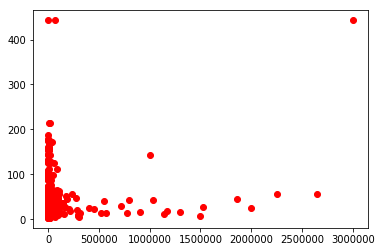

In [7]:
#ax = sns.scatterplot(x = column_names[-3], y = y_column_name, hue=column_names[-7], style=column_names[-1], data = expances_data)
y = expances_data.iloc[:, 5].values
X = expances_data.iloc[:, -4].values

plt.plot(X, y, 'ro')
plt.show()

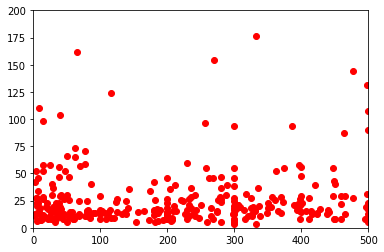

In [8]:
#sns.relplot(x=column_names[-2], y=y_column_name, hue=column_names[-3], col=column_names[-1], data=expances_data);
y = expances_data.iloc[:, 5].values
X = expances_data.iloc[:, -4].values

plt.plot(X, y, 'ro')
plt.axis([0, 500, 0, 200])
plt.show()

下面这段代码清除了只在一个行业消费的用户数据
只在一个行业消费是不现实的，当用户只在一个行业消费时，用户的消费数据不能体现用户的消费能力和
经济水平，所以不能作为预测用户车辆价值的相关因素

In [9]:
pcent = raw_data.iloc[:, 67]
pcent = pcent.drop(pcent[pcent == 100.].index)  #找到TOP1行业消费100%的数据并清除它
new_expances_data = pd.merge(expances_data, pcent.to_frame(name='TOP1行业消费占比'), on='userid')
new_expances_data.dropna(how='any')  #清楚所有空数据
new_expances_data

,型号,品牌,年份,最低报价,最高报价,中间报价,报价,性别,年龄段,借记卡数,贷记卡数,近1年单笔交易金额最大值,近1年消费总笔数,近1年消费总金额,消费城市数量,TOP1行业消费占比
userid,,,,,,,,,,,,,,,,
3,A6,奥迪,2002.0,30.8,54.2,42.50,[ 30.8 - 54.2 ] 万,男,4.0,2,0,1660.00,5,3194.00,1,51.97
6,福克斯,福特,2009.0,11.9,15.4,13.65,[ 11.9 - 15.4 ] 万,男,5.0,1,1,2374.10,18,7519.25,3,59.73
7,福克斯,福特,2009.0,11.9,15.4,13.65,[ 11.9 - 15.4 ] 万,女,5.0,1,0,2450.00,6,5671.68,1,56.42
10,宝来,大众,2011.0,10.8,14.8,12.80,[ 10.8 - 14.8 ] 万,女,5.0,2,1,500.00,4,1089.70,1,54.12
18,速腾,大众,2012.0,13.2,22.6,17.90,[ 13.2 - 22.6 ] 万,男,4.0,0,2,235.28,3,268.28,1,87.70
21,佳乐,起亚,2007.0,14.7,18.3,16.50,[ 14.7 - 18.3 ] 万,男,4.0,0,1,3203.00,9,8931.00,3,35.86
22,SRX,凯迪拉克,2010.0,40.0,59.8,49.90,[ 40.0 - 59.8 ] 万,女,4.0,1,1,20000.00,16,31764.05,2,62.96
24,Q5,奥迪,2010.0,38.0,54.0,46.00,[ 38.0 - 54.0 ] 万,男,8.0,0,1,3000.00,11,11054.30,4,43.68
26,翼虎,福特,2013.0,19.4,27.6,23.50,[ 19.4 - 27.6 ] 万,男,5.0,1,1,514.00,9,2242.26,2,55.27


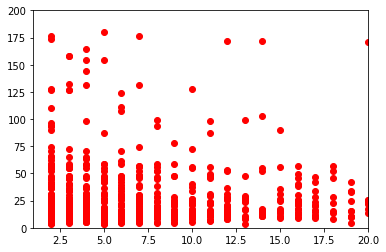

In [10]:
y = new_expances_data.iloc[:, 5].values
X = new_expances_data.iloc[:, -4].values

plt.plot(X, y, 'ro')
plt.axis([1, 20, 0, 200])
plt.show()

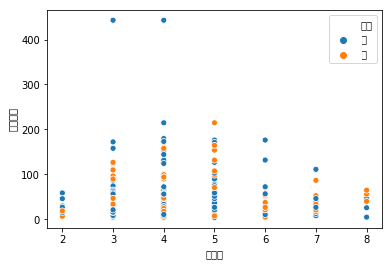

In [11]:
sns.scatterplot(x=column_names[-7], y=y_column_name, hue=column_names[7], data=new_expances_data);

下面这段代码清除了所有近1年单笔交易金额最大值与近1年月累计交易金额最大值相同的数据
当上面的两个数据相同时，说明用户在一年中只进行了一次消费，这也是不现实的，这样的数据不能
体现用户的经济能力，所以我们继续进行数据清洗，删除了这些数据

In [12]:
#先将这两栏数据相减，为0则说明数据相同
spend_pieces = [raw_data.iloc[:, 8], raw_data.iloc[:, 11]]
spend_pieces = pd.concat(spend_pieces, axis=1)
spend_pieces['差值'] = spend_pieces.iloc[:, 0] - spend_pieces.iloc[:, 1]

#从数据中删除差值为0的数据
spend_pieces = spend_pieces.drop(spend_pieces[spend_pieces['差值'] == 0.].index)
spend_pieces = spend_pieces.drop(['近1年单笔交易金额最大值', '近1年月累计交易金额最大值'], axis=1)
new_expances_data_ = pd.merge(new_expances_data, spend_pieces, on='userid')
new_expances_data_ = new_expances_data_.drop(['差值', 'TOP1行业消费占比'], axis=1)
new_expances_data_

,型号,品牌,年份,最低报价,最高报价,中间报价,报价,性别,年龄段,借记卡数,贷记卡数,近1年单笔交易金额最大值,近1年消费总笔数,近1年消费总金额,消费城市数量
userid,,,,,,,,,,,,,,,
6,福克斯,福特,2009.0,11.9,15.4,13.65,[ 11.9 - 15.4 ] 万,男,5.0,1,1,2374.10,18,7519.25,3
21,佳乐,起亚,2007.0,14.7,18.3,16.50,[ 14.7 - 18.3 ] 万,男,4.0,0,1,3203.00,9,8931.00,3
22,SRX,凯迪拉克,2010.0,40.0,59.8,49.90,[ 40.0 - 59.8 ] 万,女,4.0,1,1,20000.00,16,31764.05,2
24,Q5,奥迪,2010.0,38.0,54.0,46.00,[ 38.0 - 54.0 ] 万,男,8.0,0,1,3000.00,11,11054.30,4
26,翼虎,福特,2013.0,19.4,27.6,23.50,[ 19.4 - 27.6 ] 万,男,5.0,1,1,514.00,9,2242.26,2
27,捷达,大众,2010.0,7.6,8.9,8.25,[ 7.6 - 8.9 ] 万,女,6.0,1,0,9000.00,2,14000.00,1
28,凯美瑞,丰田,2012.0,18.0,33.0,25.50,[ 18.0 - 33.0 ] 万,男,6.0,2,1,5219.00,16,24763.39,5
35,名驭,现代,2009.0,11.5,14.0,12.75,[ 11.5 - 14.0 ] 万,男,4.0,1,4,13060.00,16,29672.40,5
39,明锐,斯柯达,2010.0,12.3,21.0,16.65,[ 12.3 - 21.0 ] 万,男,4.0,1,0,10000.00,12,46760.10,1


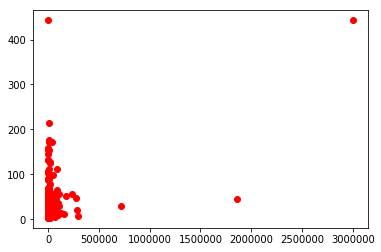

In [13]:
y = new_expances_data_.iloc[:, 5].values
X = new_expances_data_.iloc[:, -4].values

plt.plot(X, y, 'ro')
#plt.axis([0, 50000, 0, 200])
plt.show()

处理并导出清洗前的expances_data用作机器学习

In [14]:
ml_data = expances_data.iloc[:, 5:]
ml_data = ml_data.drop('报价', axis=1)
#ml_data[ml_data['性别'] == '男'].loc['性别'] = 1
ml_data['性别'] = ml_data['性别'].map({'男': 1, '女': 0})
#ml_data.to_csv('ml_data')

In [17]:
new_expances_data_ = new_expances_data_.drop(new_expances_data_[new_expances_data_['中间报价'] > 200].index)
new_expances_data_ = new_expances_data_.drop(new_expances_data_[new_expances_data_['近1年消费总金额'] > 500000].index)

ml_data = new_expances_data_.iloc[:, 5:]
ml_data = ml_data.drop('报价', axis=1)
ml_data['性别'] = ml_data['性别'].map({'男': 1, '女': 0})
#ml_data.to_csv('ml_data_cleaned')